In [52]:
import torch as tc 
from torch import optim, nn 
from torch.utils.data import TensorDataset, DataLoader, random_split, ConcatDataset 

from torchvision import transforms as T 
from torchvision.datasets import MNIST 
from torchvision.utils import make_grid, save_image 
import torchvision

from torchmetrics import Accuracy

import pandas as pd 
import matplotlib.pyplot as plt 

from tqdm import tqdm

In [26]:
device = 'cuda' if tc.cuda.is_available() else 'cpu'

In [27]:
bs = 100 
z_dim = 100
d_model = 28

In [28]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [29]:
transforms = T.Compose([T.ToTensor(), T.Normalize(mean = 0.5, std = 0.5)])

In [30]:
train_dataset = MNIST('datasets', train = True, download = True, transform = transforms)
test_dataset  = MNIST('datasets', train = False, download = True, transform = transforms)

In [31]:
dataset = ConcatDataset([train_dataset, test_dataset])

In [32]:
len(dataset)

70000

In [33]:
train_loader = DataLoader(dataset, batch_size = bs, shuffle = True)

In [34]:
x, y =next(iter(train_loader))

In [35]:
x.shape

torch.Size([100, 1, 28, 28])

In [36]:
class Generator(nn.Module):
    
    def __init__(self, d_model):
        super(Generator, self).__init__()
        
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.LazyLinear(512)
        self.fc3 = nn.LazyLinear(1024)
        self.fc4 = nn.LazyLinear(d_model * d_model)
        
    def forward(self, z, fake_label):
        
        z = tc.cat([z, fake_label], dim = 1)
        
        y = self.fc1(z)
        y = nn.LeakyReLU(0.2)(y)
        
        y = self.fc2(y)
        y = nn.LeakyReLU(0.2)(y)
        
        y = self.fc3(y)
        y = nn.LeakyReLU(0.2)(y)
        
        y = y.flatten(1)
        
        y = self.fc4(y)
        y = nn.Tanh()(y)
        
        
        return y

In [37]:
G_model = Generator(d_model).to(device)

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [38]:
fake_label = tc.randint(0, 10, (bs, 1))

In [39]:
G_model(tc.randn(bs, z_dim).to(device), fake_label.to(device)).shape

torch.Size([100, 784])

In [40]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.LazyLinear(1024)
        self.fc2 = nn.LazyLinear(512)
        self.fc3 = nn.LazyLinear(256)
        self.fc4 = nn.LazyLinear(1)
        
    def forward(self, x, label):
        
        x = x.view(bs, d_model * d_model)
        x = tc.cat([x, label], dim = 1)
        
        y = self.fc1(x)
        y = nn.LeakyReLU(0.2)(y)
        y = nn.Dropout(0.3)(y)
        
        y = self.fc2(y)
        y = nn.LeakyReLU(0.2)(y)
        y = nn.Dropout(0.3)(y)
        
        y = self.fc3(y)
        y = nn.LeakyReLU(0.2)(y)
        y = nn.Dropout(0.3)(y)
        
        y = self.fc4(y)
        y = nn.Sigmoid()(y)
        
        return y

In [41]:
D_model = Discriminator().to(device)

In [42]:
D_model(x.to(device), fake_label.to(device)).shape

torch.Size([100, 1])

In [43]:
G_model = Generator(d_model).to(device)
D_model = Discriminator().to(device)

In [44]:
optimizer_D = optim.Adam(D_model.parameters(), lr = 0.0002)
optimizer_G = optim.Adam(G_model.parameters(), lr = 0.0002)
loss_func   = nn.BCELoss()

In [45]:
loss_D_hist, loss_G_hist = [], []

In [46]:
N = 100 
for epoch in range(N):
    
    loss_D = AverageMeter()
    loss_G = AverageMeter()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for x, y in tepoch:
            
            D_model.zero_grad()
            
            if epoch is not None:
                tepoch.set_description(f'Epoch = {epoch + 1:03d}/{N}')
                
            x = x.to(device)
            y = y.to(device)
            y_real = tc.ones(100, 1).to(device)
            
            z = tc.randn(bs, z_dim).to(device)
            y_fake_G = tc.randint(0, 10, (bs, 1)).to(device)
            y_fake = tc.zeros(bs, 1).to(device)
            
            out_D = D_model(x, y.unsqueeze(1))
            loss_D_real = loss_func(out_D, y_real)
            
            out_G = G_model(z, y_fake_G)
            out_D = D_model(out_G, y_fake_G)
            loss_D_fake = loss_func(out_D, y_fake)
            
            loss_total_D = 1/2 * (loss_D_fake + loss_D_real)
            
            loss_total_D.backward()
            optimizer_D.step()
            
            loss_D.update(loss_total_D)
            
            
            G_model.zero_grad()
            z = tc.randn(bs, z_dim).to(device)
            y_fake = tc.ones(bs, 1).to(device)
            fake_label = tc.randint(0, 10, (bs, 1)).to(device)
            out_G = G_model(z, fake_label)
            out_D = D_model(out_G, fake_label)
            loss_G_real = loss_func(out_D, y_fake)
            
            loss_G_real.backward()
            optimizer_G.step()
            
            loss_G.update(loss_G_real)
            
            tepoch.set_postfix(Dis_loss = loss_D.avg.item(), Gen_loss = loss_G.avg.item())
            
    z = tc.randn(64, z_dim).to(device)
    fake = tc.randint(0, 10, (64, 1)).to(device)
    out = G_model(z, fake)
    image = out.view(64, 28, 28)
    save_image(out.view(64, 1, 28, 28), f'./AI/howsam/hw-GAN//gan-{epoch:03d}.png')
    tc.save(fake.view(8, 8), f'/home/ahmadrezabaqerzadeh/AI/howsam/hw-GAN/gan-{epoch:03d}.csv')
            
    loss_D_hist.append(loss_D.avg.item())
    loss_G_hist.append(loss_G.avg.item())

Epoch = 100/100: 100%|██████████| 700/700 [00:19<00:00, 36.32batch/s, Dis_loss=0.541, Gen_loss=1.26]


In [192]:
image = G_model(tc.randn(1, 100).to(device), tc.Tensor([6]).unsqueeze(1).to(device)).reshape(28, 28)

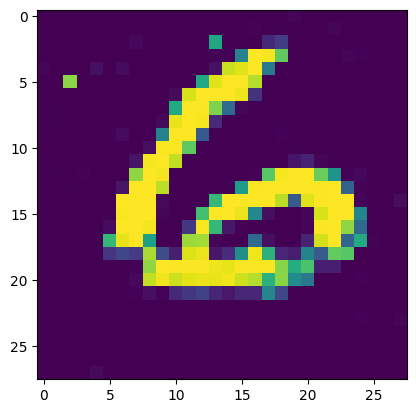

In [193]:
plt.imshow(image.cpu().detach())

In [49]:
tc.load('/home/ahmadrezabaqerzadeh/AI/howsam/hw-GAN/gan-099.csv')

tensor([[5, 9, 4, 8, 4, 0, 0, 8],
        [0, 1, 8, 5, 4, 1, 6, 9],
        [7, 1, 1, 8, 5, 5, 1, 2],
        [7, 3, 9, 8, 6, 2, 2, 4],
        [0, 8, 4, 7, 5, 5, 7, 4],
        [2, 1, 8, 3, 9, 9, 6, 3],
        [0, 1, 5, 9, 7, 6, 8, 9],
        [2, 5, 0, 2, 5, 2, 5, 1]], device='cuda:0')

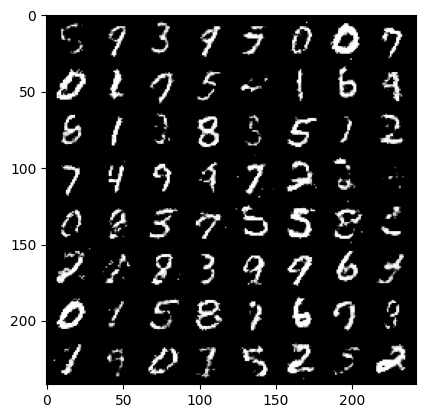

In [58]:
plt.imshow(torchvision.io.read_image('/home/ahmadrezabaqerzadeh/AI/howsam/hw-GAN/gan-099.png').permute(1, 2, 0))

In [178]:
z = tc.randn(3, 100).to(device)
label = tc.Tensor([6, 4, 8]).unsqueeze(1).to(device)
image = G_model(z, label)

In [179]:
image = image.view(3, 28, 28)
image_grid = make_grid(image.unsqueeze(1), 1)

In [180]:
image_grid.shape

torch.Size([3, 92, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


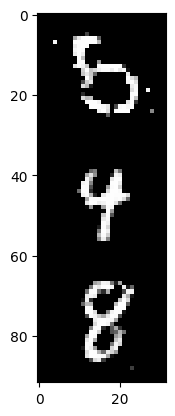

In [181]:
plt.imshow(image_grid.cpu().detach().permute(1, 2, 0))